# Dimension Reduction With AutoEncoder

# Import Library

In [1]:
import os
import gzip
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define Constants and Parameters

In [2]:
IMAGE_TRAIN_DATASET_PATH = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz'
LABEL_TRAIN_DATASET_PATH = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz'
IMAGE_TEST_DATASET_PATH = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz'
LABEL_TEST_DATASET_PATH = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz'

In [3]:
CLASS_NAMES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

In [4]:
config = {
    "learning_rate": 0.0001,
    "batch_size": 128,
    "epochs": 100,
}

# a. Load Dataset, EDA, and Splitting

In [5]:
# Load Dataset
image_list = []
label_list = []

def download_and_extract_data(url, filename):
    if not os.path.exists(filename):
        print(f"Downloading {filename}...")
        response = requests.get(url)
        with open(filename, 'wb') as f:
            f.write(response.content)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype=np.uint8, offset=16 if 'images' in filename else 8)
    return data

train_images = download_and_extract_data(IMAGE_TRAIN_DATASET_PATH, 'train-images-idx3-ubyte.gz').reshape(-1, 28, 28)
train_labels = download_and_extract_data(LABEL_TRAIN_DATASET_PATH, 'train-labels-idx1-ubyte.gz')
test_images = download_and_extract_data(IMAGE_TEST_DATASET_PATH, 't10k-images-idx3-ubyte.gz').reshape(-1, 28, 28)
test_labels = download_and_extract_data(LABEL_TEST_DATASET_PATH, 't10k-labels-idx1-ubyte.gz')

image_list = np.concatenate((train_images, test_images), axis=0)
label_list = np.concatenate((train_labels, test_labels), axis=0)

image_list = image_list.astype('float32') / 255.0
image_list = np.array(image_list)
label_list = np.array(label_list)

print(f"Images shape: {image_list.shape}, Labels shape: {label_list.shape}")

Images shape: (70000, 28, 28), Labels shape: (70000,)


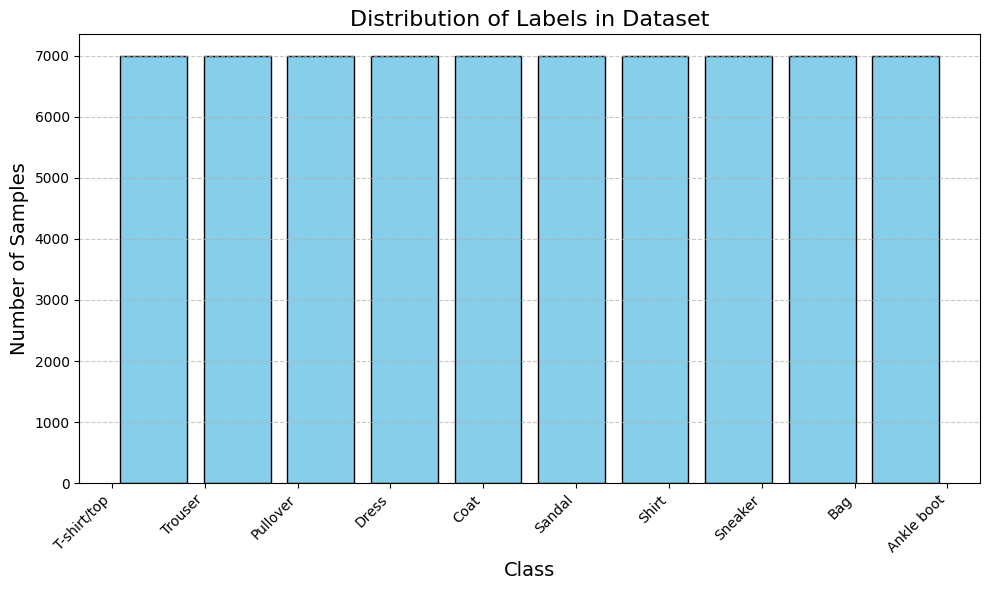

In [6]:
def plot_label_distribution(labels):
    plt.figure(figsize=(10, 6))
    plt.hist(labels, bins=10, rwidth=0.8, color='skyblue', edgecolor='black')
    plt.xticks(range(10), [CLASS_NAMES[i] for i in range(10)], rotation=45, ha='right')
    plt.title("Distribution of Labels in Dataset", fontsize=16)
    plt.xlabel("Class", fontsize=14)
    plt.ylabel("Number of Samples", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_label_distribution(label_list)

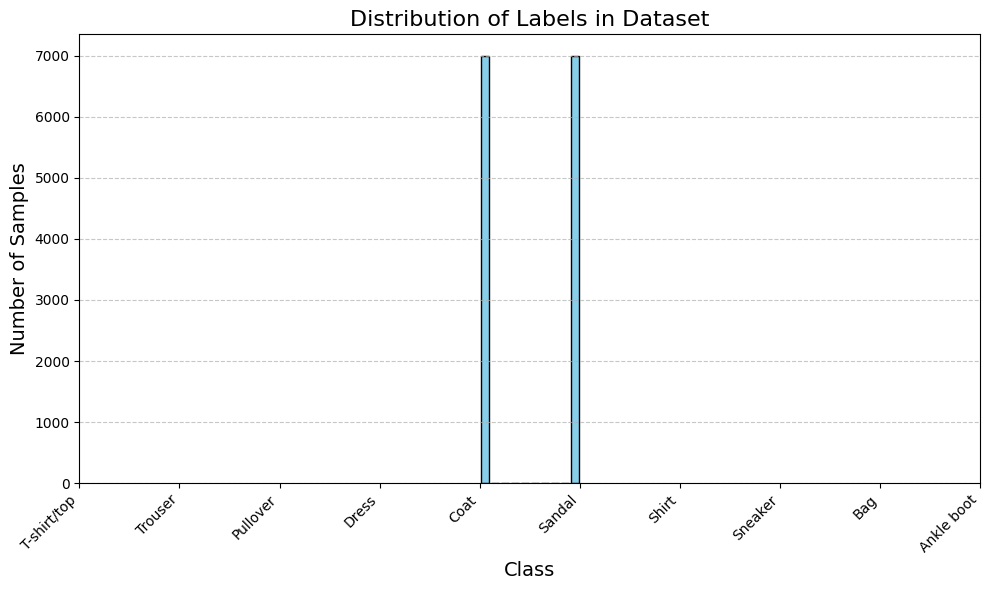

In [8]:
coat_and_sandal_mask = (label_list == 4) | (label_list == 5)
filtered_images = image_list[coat_and_sandal_mask]
filtered_labels = label_list[coat_and_sandal_mask]

plot_label_distribution(filtered_labels)

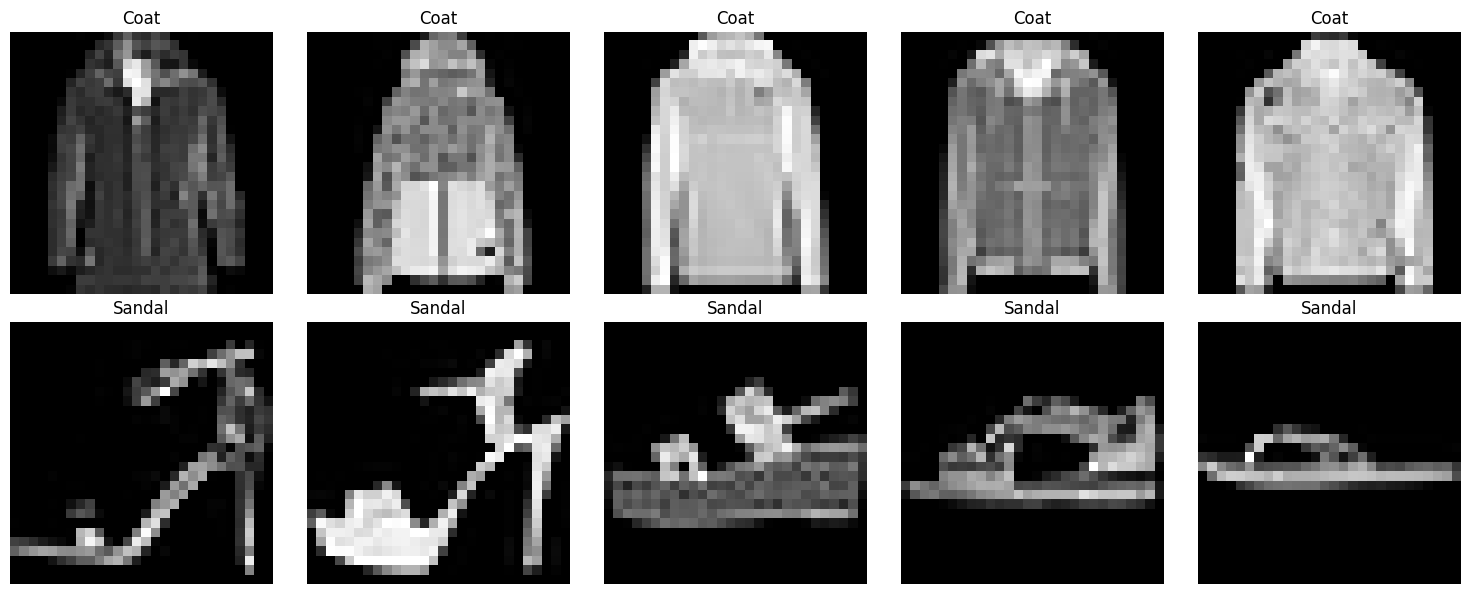

In [9]:
images_to_plot = np.vstack([filtered_images[filtered_labels == 4][:5], filtered_images[filtered_labels == 5][:5]])

plt.figure(figsize=(15, 6))
for i, img in enumerate(images_to_plot):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title("Coat" if i < 5 else "Sandal")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# Splitting 80:10:10, stratify
X_train, X_temp, y_train, y_temp = train_test_split(
    filtered_images,
    filtered_labels,
    test_size=0.2,
    random_state=42,
    stratify=filtered_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

def print_subset_info(images, labels, subset_name):
    total_samples = len(images)
    percentage = (total_samples / len(filtered_images)) * 100
    print(f"{subset_name}: {total_samples} gambar ({percentage:.1f}%)")
    unique_classes, counts = np.unique(labels, return_counts=True)
    for cls, count in zip(unique_classes, counts):
        print(f"  Class {CLASS_NAMES[cls]}: {count} samples")
    print()

print_subset_info(X_train, y_train, "Training Set")
print_subset_info(X_val, y_val, "Validation Set")
print_subset_info(X_test, y_test, "Test Set")

Training Set: 11200 gambar (80.0%)
  Class Coat: 5600 samples
  Class Sandal: 5600 samples

Validation Set: 1400 gambar (10.0%)
  Class Coat: 700 samples
  Class Sandal: 700 samples

Test Set: 1400 gambar (10.0%)
  Class Coat: 700 samples
  Class Sandal: 700 samples



# b. Define model, train, and evaluate

In [11]:
# Define AutoEncoder Class
class AutoEncoder:
    def __init__(self, input_shape=(28, 28, 1), latent_dim=128):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.autoencoder = self.build_autoencoder()

    def build_encoder(self):
        inputs = layers.Input(shape=self.input_shape, name="encoder_input")
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)
        x = layers.Flatten()(x)
        outputs = layers.Dense(self.latent_dim, activation="relu", name="latent_vector")(x)
        return models.Model(inputs, outputs, name="encoder")

    def build_decoder(self):
        inputs = layers.Input(shape=(self.latent_dim,), name="decoder_input")
        x = layers.Dense(6272, activation="relu")(inputs)
        x = layers.Reshape((14, 14, 32))(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
        outputs = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

        return models.Model(inputs, outputs, name="decoder")

    def build_autoencoder(self):
        inputs = layers.Input(shape=self.input_shape, name="autoencoder_input")
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return models.Model(inputs, decoded, name="autoencoder")

In [12]:
autoencoder = AutoEncoder(input_shape=(28, 28, 1), latent_dim=128)
autoencoder.autoencoder.compile(optimizer=Adam(learning_rate=config["learning_rate"]), loss="binary_crossentropy")

In [13]:
print("Encoder Summary:")
autoencoder.encoder.summary()

Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 128)                 │         802,944 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 803,264 (3.06 MB)

 Trainable params: 803,264 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print("Decoder Summary:")
autoencoder.decoder.summary()

Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 818,625 (3.12 MB)

 Trainable params: 818,625 (3.12 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
print("Autoencoder Summary:")
autoencoder.autoencoder.summary()

Autoencoder Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)       │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 128)                 │         803,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │         818,625 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,621,889 (6.19 MB)

 Trainable params: 1,621,889 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Add earlystopper
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train Autoencoder
history = autoencoder.autoencoder.fit(
    X_train, X_train,
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    validation_data=(X_val, X_val),
    callbacks=[early_stopping]
)

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.6211 - val_loss: 0.3819
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3687 - val_loss: 0.3254
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3196 - val_loss: 0.3013
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3024 - val_loss: 0.2902
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2929 - val_loss: 0.2828
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2862 - val_loss: 0.2767
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2797 - val_loss: 0.2721
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2755 - val_loss: 0.2683
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2710 - val_loss: 0.2651
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2679 - val_loss: 0.2624
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2663 - val_loss: 0.2602
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

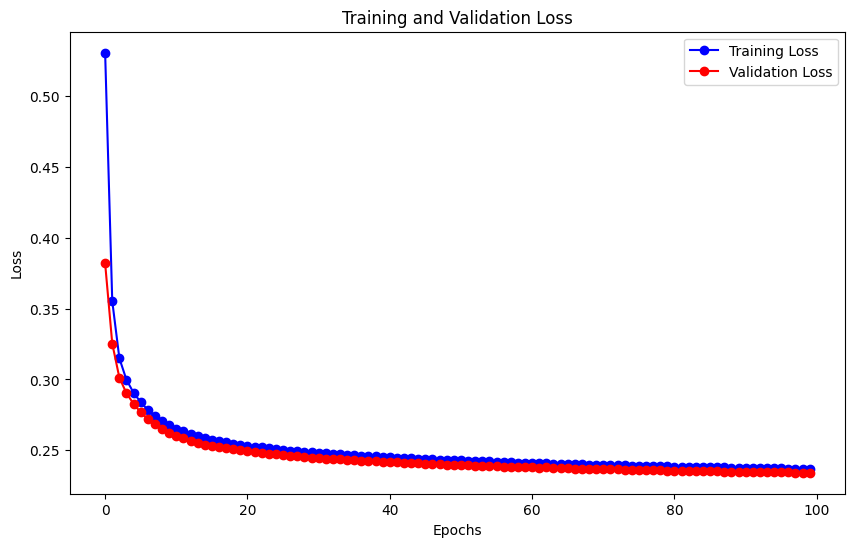

In [17]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], 'bo-', label='Training Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate
test_loss = autoencoder.autoencoder.evaluate(X_test, X_test)
print(f"Test Loss: {test_loss:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2404
Test Loss: 0.2383


In [19]:
# Calculate SSIM between original and reconstructed images
def calculate_ssim(original_images, reconstructed_images):
    ssim_values = []
    for original, reconstructed in zip(original_images, reconstructed_images):
        original = original.squeeze()
        reconstructed = reconstructed.squeeze()
        ssim_value = ssim(original, reconstructed, data_range=1.0)
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

reconstructed_images = autoencoder.autoencoder.predict(X_test)
ssim_score = calculate_ssim(X_test, reconstructed_images)
print(f"SSIM pada data test: {ssim_score:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SSIM pada data test: 0.8585


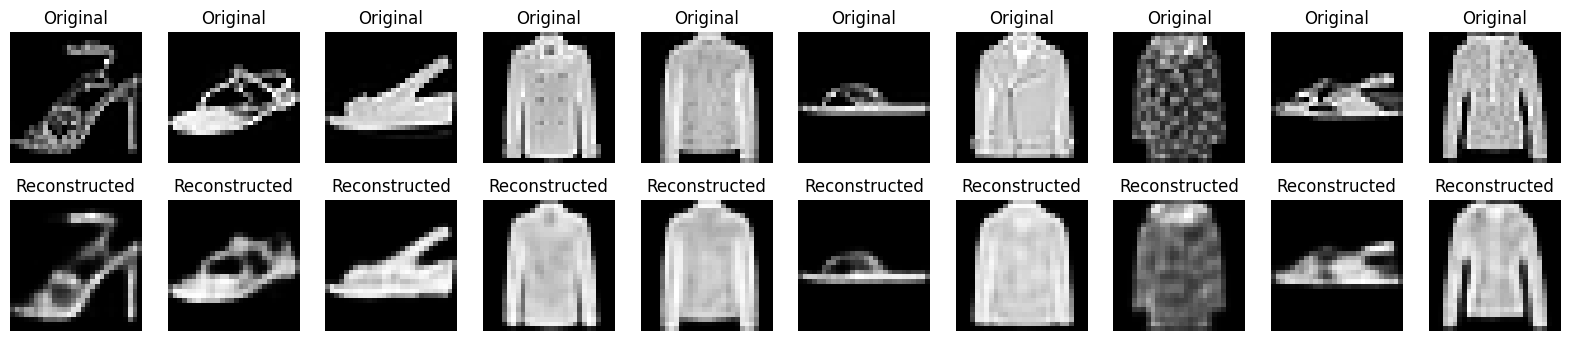

In [20]:
def visualize_reconstructions(original_images, reconstructed_images, modified_reconstructed_images=None, n=10):
    plt.figure(figsize=(20, 4 if modified_reconstructed_images is None else 6))
    
    for i in range(n):
        ax = plt.subplot(2 if modified_reconstructed_images is None else 3, n, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        ax = plt.subplot(2 if modified_reconstructed_images is None else 3, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].squeeze(), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")

        if modified_reconstructed_images is not None:
            ax = plt.subplot(3, n, i + 1 + 2 * n)
            plt.imshow(modified_reconstructed_images[i].squeeze(), cmap="gray")
            plt.title("M-Reconstructed")
            plt.axis("off")
    
    plt.show()

visualize_reconstructions(X_test, reconstructed_images, n=10)

In [21]:
autoencoder.autoencoder.save('autoencoder_model.h5')

# c. Modification Architecture and Hyperparameter Tuning

In [22]:
config = {
    "epochs": 100,
}

# Define Parameter for Grid Search
param_grid = {
    "learning_rate": [0.0001, 0.001, 0.01, 0.0002],
    "batch_size": [64, 128, 256],
    "latent_dim": [128, 256]
}

grid = ParameterGrid(param_grid)

In [23]:
class ModifiedAutoEncoder:
    def __init__(self, input_shape=(28, 28, 1), latent_dim=128):
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.autoencoder = self.build_autoencoder()

    def build_encoder(self):
        inputs = layers.Input(shape=self.input_shape, name="encoder_input")
        x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)
        x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Flatten()(x)
        outputs = layers.Dense(self.latent_dim, activation="relu", name="latent_vector")(x)
        return models.Model(inputs, outputs, name="encoder")

    def build_decoder(self):
        inputs = layers.Input(shape=(self.latent_dim,), name="decoder_input")
        x = layers.Dense(25088, activation="relu")(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Reshape((14, 14, 128))(x)
        x = layers.UpSampling2D((2, 2))(x)
        x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = layers.BatchNormalization()(x)
        outputs = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

        return models.Model(inputs, outputs, name="decoder")

    def build_autoencoder(self):
        inputs = layers.Input(shape=self.input_shape, name="autoencoder_input")
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return models.Model(inputs, decoded, name="autoencoder")

In [24]:
best_model = None
best_ssim_score = -1

# Train and Evaluate function to find the best parameters
def train_and_evaluate(learning_rate, batch_size, latent_dim, X_train, X_val, X_test):
    global best_model, best_ssim_score

    modified_autoencoder = ModifiedAutoEncoder(
        input_shape=(28, 28, 1),
        latent_dim=latent_dim
    )

    modified_autoencoder.autoencoder.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy"
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )

    history = modified_autoencoder.autoencoder.fit(
        X_train, X_train,
        epochs=config["epochs"],
        batch_size=batch_size,
        validation_data=(X_val, X_val),
        callbacks=[early_stopping],
        verbose=0
    )

    reconstructed_images = modified_autoencoder.autoencoder.predict(X_test, verbose=0)
    test_loss = modified_autoencoder.autoencoder.evaluate(X_test, X_test)
    ssim_score = calculate_ssim(X_test, reconstructed_images)

    if ssim_score > best_ssim_score:
        best_ssim_score = ssim_score
        best_model = modified_autoencoder
        print(f"New best model found with SSIM score: {ssim_score:.4f}")

    return ssim_score, test_loss

In [25]:
results = []

for params in grid:
    print(f"Testing params: {params}")
    ssim_score, test_loss = train_and_evaluate(params["learning_rate"], params["batch_size"], params["latent_dim"], X_train, X_val, X_test)
    results.append({
        "params": params,
        "ssim_score": ssim_score,
        "test_loss": test_loss
    })
    print(f"SSIM Score: {ssim_score:.4f}, Test Loss: {test_loss:.4f}\n")

Testing params: {'batch_size': 64, 'latent_dim': 128, 'learning_rate': 0.0001}
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2385
New best model found with SSIM score: 0.8794
SSIM Score: 0.8794, Test Loss: 0.2363

Testing params: {'batch_size': 64, 'latent_dim': 128, 'learning_rate': 0.001}
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2385
SSIM Score: 0.8753, Test Loss: 0.2362

Testing params: {'batch_size': 64, 'latent_dim': 128, 'learning_rate': 0.01}
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2394
New best model found with SSIM score: 0.8835
SSIM Score: 0.8835, Test Loss: 0.2373

Testing params: {'batch_size': 64, 'latent_dim': 128, 'learning_rate': 0.0002}
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2374
New best model found with SSIM score: 0.8853
SSIM Score: 0.8853, Test Loss: 0.2352

Testing params: {'batch_size': 64, 'latent_dim': 256, 'learning_rate': 0.0001}
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2342
New best model found with SSIM score: 0.9055


In [26]:
best_result = max(results, key=lambda x: x["ssim_score"])
print("Best Hyperparameters:")
print(best_result["params"])
print(f"Best SSIM Score: {best_result['ssim_score']:.4f}")

Best Hyperparameters:
{'batch_size': 64, 'latent_dim': 256, 'learning_rate': 0.001}
Best SSIM Score: 0.9163


In [27]:
reconstructed_images = autoencoder.autoencoder.predict(X_test)
ssim_score = calculate_ssim(X_test, reconstructed_images)
print(f"SSIM pada data test (Baseline): {ssim_score:.4f}")

modified_reconstructed_images = best_model.autoencoder.predict(X_test)
ssim_score = calculate_ssim(X_test, modified_reconstructed_images)
print(f"SSIM pada data test (Modified): {ssim_score:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
SSIM pada data test (Baseline): 0.8585
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
SSIM pada data test (Modified): 0.9163


In [28]:
print("Modified Encoder Summary:")
best_model.encoder.summary()

Modified Encoder Summary:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_vector (Dense)                │ (None, 256)                 │       6,422,784 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,498,048 (24.79 MB)

 Trainable params: 6,497,664 (24.79 MB)

 Non-trainable params: 384 (1.50 KB)

In [29]:
print("Modified Decoder Summary:")
best_model.decoder.summary()

Modified Decoder Summary:


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25088)               │       6,447,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 25088)               │         100,352 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_6 (Reshape)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_6 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 28, 28, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,770,689 (25.83 MB)

 Trainable params: 6,720,129 (25.64 MB)

 Non-trainable params: 50,560 (197.50 KB)

In [30]:
print("Modified Autoencoder Summary:")
best_model.autoencoder.summary()

Modified Autoencoder Summary:


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)       │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (None, 256)                 │       6,498,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 28, 28, 1)           │       6,770,689 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 39,704,325 (151.46 MB)

 Trainable params: 13,217,793 (50.42 MB)

 Non-trainable params: 50,944 (199.00 KB)

 Optimizer params: 26,435,588 (100.84 MB)

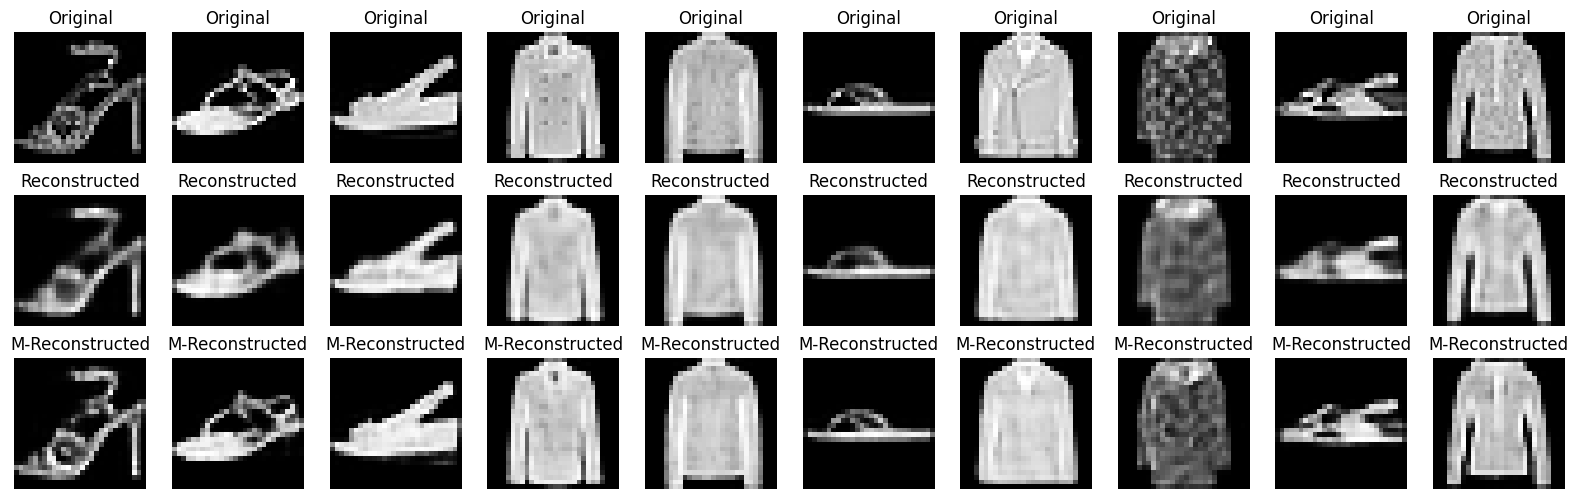

In [31]:
modified_reconstructed_images = best_model.autoencoder.predict(X_test, verbose=0)
visualize_reconstructions(X_test, reconstructed_images, modified_reconstructed_images, n=10)

In [32]:
best_model.autoencoder.save('modified_autoencoder_model.h5')